In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms.functional as F
import warnings
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.exceptions import UndefinedMetricWarning
import torch.nn.functional as nnF
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [2]:
def getting_pictures_path(path_folder):
  path_pictures = [os.path.join(path_folder, folder) for folder in os.listdir(path_folder) if not folder.startswith(".")]
  return path_pictures

pictures_path = getting_pictures_path("/content/drive/MyDrive/Dataset/transistor/train/good")
print(pictures_path)

['/content/drive/MyDrive/Dataset/transistor/train/good/028.png', '/content/drive/MyDrive/Dataset/transistor/train/good/031.png', '/content/drive/MyDrive/Dataset/transistor/train/good/022.png', '/content/drive/MyDrive/Dataset/transistor/train/good/036.png', '/content/drive/MyDrive/Dataset/transistor/train/good/007.png', '/content/drive/MyDrive/Dataset/transistor/train/good/000.png', '/content/drive/MyDrive/Dataset/transistor/train/good/008.png', '/content/drive/MyDrive/Dataset/transistor/train/good/032.png', '/content/drive/MyDrive/Dataset/transistor/train/good/001.png', '/content/drive/MyDrive/Dataset/transistor/train/good/003.png', '/content/drive/MyDrive/Dataset/transistor/train/good/025.png', '/content/drive/MyDrive/Dataset/transistor/train/good/038.png', '/content/drive/MyDrive/Dataset/transistor/train/good/006.png', '/content/drive/MyDrive/Dataset/transistor/train/good/020.png', '/content/drive/MyDrive/Dataset/transistor/train/good/034.png', '/content/drive/MyDrive/Dataset/transis

In [3]:
class DatasetTrain(Dataset):
  def __init__(self, path_pictures):
    self.path_pictures = path_pictures
    self.size = (256,256)

  def __len__(self):
    return len(self.path_pictures)

  def __getitem__(self, index):
    path_picture = self.path_pictures[index]
    picture = Image.open(path_picture).convert("L")
    angle = random.uniform(-10, 10)
    flip = random.random() > 0.5
    picture = F.rotate(picture, angle)
    if flip:
      picture = F.hflip(picture)
    picture = F.resize(picture, self.size)
    picture = F.to_tensor(picture)
    return picture


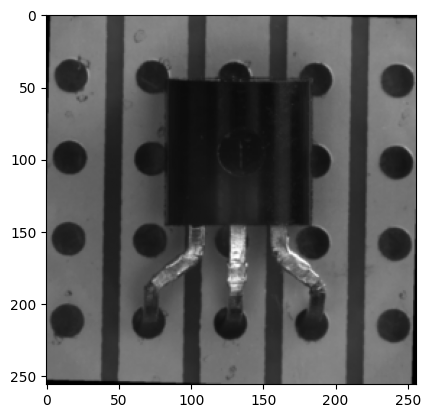

In [4]:
dataset = DatasetTrain(pictures_path)
batch = next(iter(dataset))
plt.subplot()
plt.imshow(batch[0], cmap = "gray")
plt.show()

In [5]:
class Encoder(nn.Module):
  def __init__(self, in_ch = 1, latent_space = 50):
    super().__init__()
    self.f1_conv = nn.Conv2d(in_ch,32,kernel_size=(4,4), stride = 2, padding = 1)
    self.f2_conv = nn.Conv2d(32,32,kernel_size=(4,4), stride = 2, padding = 1)
    self.f3_conv = nn.Conv2d(32,32,kernel_size=(4,4), stride = 2, padding = 1)
    self.f4_conv = nn.Conv2d(32,32,kernel_size=(3,3), stride = 1, padding = 1)
    self.f5_conv = nn.Conv2d(32,64,kernel_size=(4,4), stride = 2, padding = 1)
    self.f6_conv = nn.Conv2d(64,64,kernel_size=(3,3), stride = 1, padding = 1)
    self.f7_conv = nn.Conv2d(64,128,kernel_size=(4,4), stride = 2, padding = 1)
    self.f8_conv = nn.Conv2d(128,64,kernel_size=(3,3), stride = 1, padding = 1)
    self.f9_conv = nn.Conv2d(64,32,kernel_size=(3,3), stride = 1, padding = 1)
    self.f10_conv = nn.Conv2d(32,latent_space,kernel_size=(8,8), stride = 1, padding = 0)
    self.leaky_relu = nn.LeakyReLU(0.2)

  def forward(self, x):
    x = self.leaky_relu(self.f1_conv(x))
    x = self.leaky_relu(self.f2_conv(x))
    x = self.leaky_relu(self.f3_conv(x))
    x = self.leaky_relu(self.f4_conv(x))
    x = self.leaky_relu(self.f5_conv(x))
    x = self.leaky_relu(self.f6_conv(x))
    x = self.leaky_relu(self.f7_conv(x))
    x = self.leaky_relu(self.f8_conv(x))
    x = self.leaky_relu(self.f9_conv(x))
    x = self.f10_conv(x)
    return x

In [6]:
model = Encoder(in_ch = 1, latent_space = 50)
batch = next(iter(dataset))
batch = batch.unsqueeze(0)
print(batch.shape)
output = model(batch)
print(output.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 50, 1, 1])


In [7]:
class Decoder(nn.Module):
    def __init__(self, in_ch=1, latent_space=50):
        super().__init__()

        self.f1_upconv = nn.ConvTranspose2d(
            latent_space, 32, kernel_size=8, stride=1, padding=0
        )  # 1x1 → 8x8

        self.f2_upconv = nn.ConvTranspose2d(
            32, 64, kernel_size=3, stride=1, padding=1
        )  # 8x8

        self.f3_upconv = nn.ConvTranspose2d(
            64, 128, kernel_size=3, stride=1, padding=1
        )  # 8x8

        self.f4_upconv = nn.ConvTranspose2d(
            128, 64, kernel_size=4, stride=2, padding=1
        )  # 8x8 → 16x16

        self.f5_upconv = nn.ConvTranspose2d(
            64, 64, kernel_size=3, stride=1, padding=1
        )  # 16x16

        self.f6_upconv = nn.ConvTranspose2d(
            64, 32, kernel_size=4, stride=2, padding=1
        )  # 16x16 → 32x32

        self.f7_upconv = nn.ConvTranspose2d(
            32, 32, kernel_size=3, stride=1, padding=1
        )  # 32x32

        self.f8_upconv = nn.ConvTranspose2d(
            32, 32, kernel_size=4, stride=2, padding=1
        )  # 32x32 → 64x64

        self.f9_upconv = nn.ConvTranspose2d(
            32, in_ch, kernel_size=4, stride=2, padding=1
        )  # 64x64 → 128x128

        self.f10_upconv = nn.ConvTranspose2d(
            in_ch, in_ch, kernel_size=4, stride=2, padding=1
        )  # 64x64 → 128x128
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky_relu(self.f1_upconv(x))
        x = self.leaky_relu(self.f2_upconv(x))
        x = self.leaky_relu(self.f3_upconv(x))
        x = self.leaky_relu(self.f4_upconv(x))
        x = self.leaky_relu(self.f5_upconv(x))
        x = self.leaky_relu(self.f6_upconv(x))
        x = self.leaky_relu(self.f7_upconv(x))
        x = self.leaky_relu(self.f8_upconv(x))
        x = self.leaky_relu(self.f9_upconv(x))
        x = self.f10_upconv(x)
        return x


In [8]:
model = Decoder(in_ch = 1, latent_space = 50)
model.eval()
x = torch.randn(1,50,1,1)
print(x.shape)
output = model(x)
print(output.shape)

torch.Size([1, 50, 1, 1])
torch.Size([1, 1, 256, 256])


In [9]:
class AutoEncodeur(nn.Module):
  def __init__(self, in_ch = 1, latent_space = 50):
    super().__init__()
    self.encoder = Encoder(in_ch, latent_space)
    self.decoder = Decoder(in_ch, latent_space)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [10]:
model = AutoEncodeur(in_ch = 1, latent_space = 100)
batch = next(iter(dataset))
batch = batch.unsqueeze(0)
print(batch.shape)
output = model(batch)
print(output.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncodeur(in_ch=1, latent_space = 100).to(device)

In [16]:


def ssim(img1, img2, window_size=11, C1=0.01**2, C2=0.03**2):
    """
    img1, img2: tensors [B, C, H, W] avec valeurs dans [0, 1]
    """
    # filtre moyenne (gaussien simplifié)
    mu1 = nnF.avg_pool2d(img1, window_size, stride=1, padding=window_size//2)
    mu2 = nnF.avg_pool2d(img2, window_size, stride=1, padding=window_size//2)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = nnF.avg_pool2d(img1 ** 2, window_size, 1, window_size//2) - mu1_sq
    sigma2_sq = nnF.avg_pool2d(img2 ** 2, window_size, 1, window_size//2) - mu2_sq
    sigma12 = nnF.avg_pool2d(img1 * img2, window_size, 1, window_size//2) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean()

def gradient_loss(x, y):
    dx_x = x[..., 1:] - x[..., :-1]
    dx_y = y[..., 1:] - y[..., :-1]
    dy_x = x[..., 1:, :] - x[..., :-1, :]
    dy_y = y[..., 1:, :] - y[..., :-1, :]

    return (dx_x - dx_y).abs().mean() + (dy_x - dy_y).abs().mean()

In [17]:
dataset = DatasetTrain(pictures_path)
loader = DataLoader(dataset, batch_size=8, shuffle=True)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    betas=(0.9, 0.999)
)

alpha = 0.8


epochs = 200
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for img in loader:
        # Move tensors to the appropriate device
        img = img.to(device)

        optimizer.zero_grad()

        outputs = model(img)
        loss =  alpha * (1 - ssim(outputs, img)) + (1- alpha) * nnF.l1_loss(outputs, img)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {running_loss/len(loader):.4f}")

Epoch 1 - Loss: 0.8434
Epoch 2 - Loss: 0.7433
Epoch 3 - Loss: 0.6287
Epoch 4 - Loss: 0.5972
Epoch 5 - Loss: 0.5786
Epoch 6 - Loss: 0.5627
Epoch 7 - Loss: 0.5470
Epoch 8 - Loss: 0.5284
Epoch 9 - Loss: 0.5140
Epoch 10 - Loss: 0.5136
Epoch 11 - Loss: 0.5069
Epoch 12 - Loss: 0.5021
Epoch 13 - Loss: 0.4980
Epoch 14 - Loss: 0.5000
Epoch 15 - Loss: 0.4964
Epoch 16 - Loss: 0.4954
Epoch 17 - Loss: 0.4943
Epoch 18 - Loss: 0.4931
Epoch 19 - Loss: 0.4862
Epoch 20 - Loss: 0.4859
Epoch 21 - Loss: 0.4886
Epoch 22 - Loss: 0.4838
Epoch 23 - Loss: 0.4845
Epoch 24 - Loss: 0.4819
Epoch 25 - Loss: 0.4842
Epoch 26 - Loss: 0.4835
Epoch 27 - Loss: 0.4863
Epoch 28 - Loss: 0.4842
Epoch 29 - Loss: 0.4839
Epoch 30 - Loss: 0.4813
Epoch 31 - Loss: 0.4777
Epoch 32 - Loss: 0.4824
Epoch 33 - Loss: 0.4793
Epoch 34 - Loss: 0.4805
Epoch 35 - Loss: 0.4788
Epoch 36 - Loss: 0.4779
Epoch 37 - Loss: 0.4764
Epoch 38 - Loss: 0.4773
Epoch 39 - Loss: 0.4782
Epoch 40 - Loss: 0.4754
Epoch 41 - Loss: 0.4718
Epoch 42 - Loss: 0.4741
E

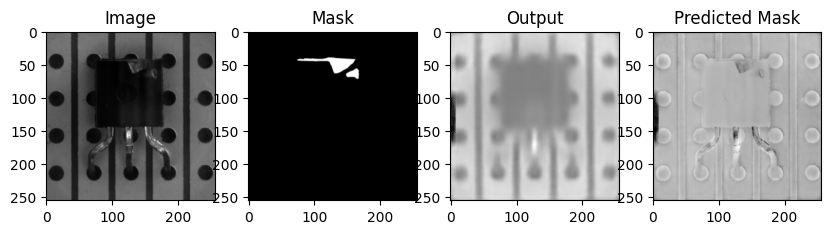

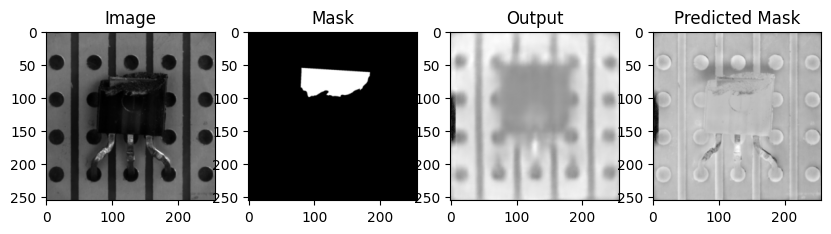

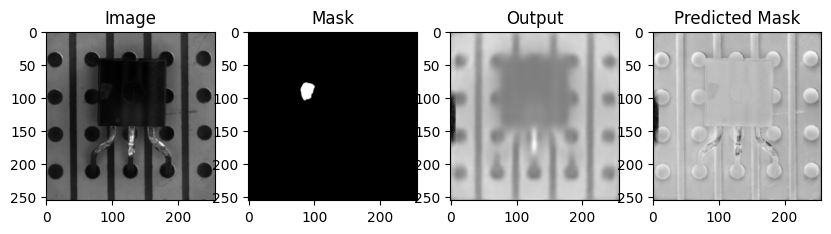

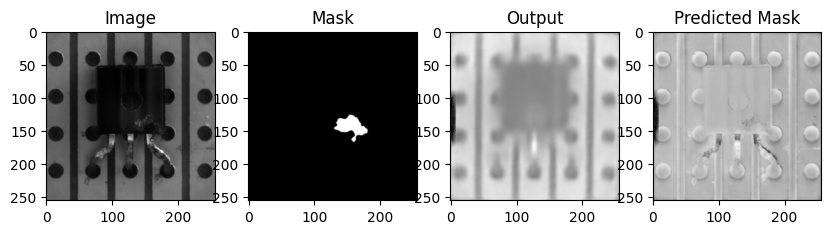

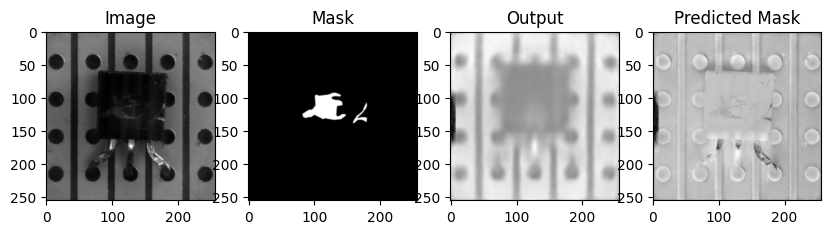

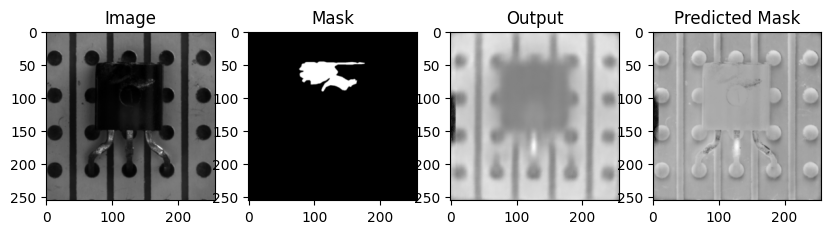

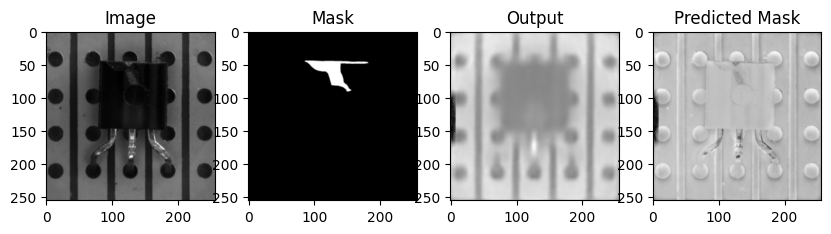

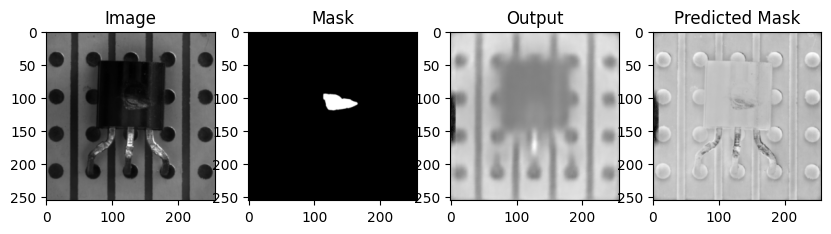

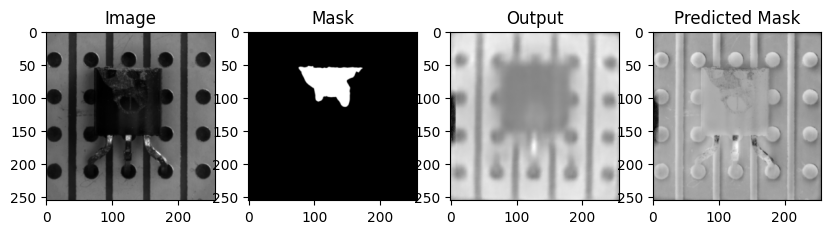

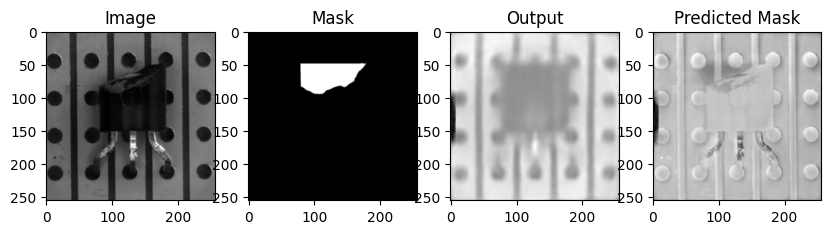

In [18]:
IMG_SIZE = (256, 256)

for j in range(10):
  path_image = f"/content/drive/MyDrive/Dataset/transistor/test/damaged_case/00{j}.png"
  path_mask  = f"/content/drive/MyDrive/Dataset/transistor/ground_truth/damaged_case/00{j}_mask.png"

  # -----------------------
  # TRANSFORMS
  # -----------------------
  img_transform = T.Compose([
      T.Resize(IMG_SIZE),
      T.ToTensor()
  ])

  mask_transform = T.Compose([
      T.Resize(IMG_SIZE),
      T.ToTensor()   # -> [0,1]
  ])

  # -----------------------
  # LOAD DATA
  # -----------------------
  image = Image.open(path_image).convert("L")
  mask  = Image.open(path_mask).convert("L")

  img_norm = img_transform(image)
  mask_norm = mask_transform(mask)


  model.eval()
  with torch.no_grad():
      image_tensor = img_norm.unsqueeze(0).to(device)
      output = model(image_tensor)
  predicted_mask = output.squeeze().cpu().numpy() - img_norm.squeeze().cpu().numpy()

  fig, ax = plt.subplots(1, 4, figsize=(10, 5))
  ax[0].imshow(img_norm.squeeze().cpu().numpy(), cmap="gray")
  ax[0].set_title("Image")
  ax[1].imshow(mask_norm.squeeze().cpu().numpy(), cmap="gray")
  ax[1].set_title("Mask")
  ax[2].imshow(output.squeeze().cpu().numpy(), cmap="gray")
  ax[2].set_title("Output")
  ax[3].imshow(predicted_mask, cmap="gray")
  ax[3].set_title("Predicted Mask")
  plt.show()

In [19]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Dataset/weight_models/Def_Trans_5gen.pth")